In [ ]:
import argparse
import os
from matplotlib.axes import Axes
from matplotlib.ticker import FuncFormatter
import yaml
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns
import gzip
import pickle
import re
import sys
import subprocess

from scipy.integrate import simpson
from scipy.stats import ks_2samp
from scipy.spatial.distance import directed_hausdorff
from scipy.stats import wasserstein_distance

from sklearn.decomposition import PCA
from umap import UMAP

from omegaconf import OmegaConf
from typing import Optional

from decifer.utility import extract_space_group_symbol, space_group_symbol_to_number

from multiprocessing import Pool, cpu_count

def rwp(sample, gen):
    """
    Calculates the residual (un)weighted profile between a sample and a generated XRD pattern
    """
    return np.sqrt(np.sum(np.square(sample - gen), axis=-1) / np.sum(np.square(sample), axis=-1))

def r2(sample, gen):
    """
    Calculates the R^2 between a sample and a generated XRD pattern
    """
    return 1 - np.sum((sample - gen)**2) / np.sum((sample - np.mean(sample))**2)

def s12(y1, y2, l=2, s_range=np.arange(-500,501)):
    def triangular_weighting(s, l):
        return np.maximum(0, 1 - np.abs(s) / l)
    
    def cross_correlation(y1, y2, s_range):
        return [np.sum(y1 * np.roll(y2, shift)) for shift in s_range]

    c12 = cross_correlation(y1, y2, s_range)
    c11 = cross_correlation(y1, y1, s_range)
    c22 = cross_correlation(y2, y2, s_range)

    weights = triangular_weighting(s_range, l)
    weighted_c12 = weights * c12
    weighted_c11 = weights * c11
    weighted_c22 = weights * c22

    numerator = simpson(weighted_c12, x=s_range)
    denominator = np.sqrt(simpson(weighted_c11, x=s_range) * simpson(weighted_c22, x=s_range))
    return numerator / denominator if denominator != 0 else 0

def soap_distance(sample, gen):
    """
    Calculates the normalized soap distance between sample and gen soap descriptors
    """
    return np.dot(sample, gen) / (np.linalg.norm(sample) * np.linalg.norm(gen))

def cohen_d(sample1, sample2):
    mean_diff = np.mean(sample1) - np.mean(sample2)
    pooled_std = np.sqrt((np.var(sample1) + np.var(sample2)) / 2)
    return mean_diff / pooled_std

def ks_test(sample1, sample2):
    statistic, p_value = ks_2samp(sample1, sample2)
    return statistic, p_value

def percentile_improvement(new_values, reference_values, percentile=75):
    threshold = np.percentile(reference_values, percentile)
    return np.mean(new_values > threshold)

def process_file(file_path):
    """Processes a single .pkl.gz file."""
    try:
        with gzip.open(file_path, 'rb') as f:
            row = pickle.load(f)

        if 'success' not in row['status']:# != 'success':
            return None

        # Extract Validity
        formula_validity = row['validity']['formula']
        bond_length_validity = row['validity']['bond_length']
        spacegroup_validity = row['validity']['spacegroup']
        site_multiplicity_validity = row['validity']['site_multiplicity']

        # Full validity check
        valid = all([formula_validity, bond_length_validity, spacegroup_validity, site_multiplicity_validity])

        # Extract CIFs and descriptors
        cif_sample = row['cif_sample']
        cif_gen = row['cif_gen']

        xrd_dirty_from_sample = row['descriptors']['xrd_dirty_from_sample']['iq']
        xrd_clean_from_sample = row['descriptors']['xrd_clean_from_sample']['iq']
        xrd_clean_from_gen = row['descriptors']['xrd_clean_from_gen']['iq']

        xrd_disc_clean_from_sample = row['descriptors']['xrd_clean_from_sample']['iq_disc']
        xrd_disc_clean_from_gen = row['descriptors']['xrd_clean_from_gen']['iq_disc']
        q_disc_clean_from_sample = row['descriptors']['xrd_clean_from_sample']['q_disc']
        q_disc_clean_from_gen = row['descriptors']['xrd_clean_from_gen']['q_disc']

        disc_clean_from_sample = np.vstack((q_disc_clean_from_sample, xrd_disc_clean_from_sample)).T
        disc_clean_from_gen = np.vstack((q_disc_clean_from_gen, xrd_disc_clean_from_gen)).T
        hd_clean_value_1 = directed_hausdorff(disc_clean_from_sample, disc_clean_from_gen, seed=42)[0]
        hd_clean_value_2 = directed_hausdorff(disc_clean_from_gen, disc_clean_from_sample, seed=42)[0]

        ws_clean_value = wasserstein_distance(q_disc_clean_from_sample, q_disc_clean_from_gen, u_weights=xrd_disc_clean_from_sample, v_weights=xrd_disc_clean_from_gen)

        xrd_q = row['descriptors']['xrd_clean_from_gen']['q']
        soap_small_sample = row['descriptors']['soap_small_sample']
        soap_small_gen = row['descriptors']['soap_small_gen']
        soap_large_sample = row['descriptors']['soap_large_sample']
        soap_large_gen = row['descriptors']['soap_large_gen']

        seq_len_sample = row['seq_len_sample']
        seq_len_gen = row['seq_len_gen']

        # Calculate metrics
        rwp_dirty_value = rwp(xrd_dirty_from_sample, xrd_clean_from_gen)
        rwp_clean_value = rwp(xrd_clean_from_sample, xrd_clean_from_gen)
        s12_dirty_value = s12(xrd_dirty_from_sample, xrd_clean_from_gen)
        s12_clean_value = s12(xrd_clean_from_sample, xrd_clean_from_gen)
        hd_clean_value = max(hd_clean_value_1, hd_clean_value_2)
        r2_dirty_value = r2(xrd_dirty_from_sample, xrd_clean_from_gen)
        r2_clean_value = r2(xrd_clean_from_sample, xrd_clean_from_gen)
        distance_small = soap_distance(soap_small_sample, soap_small_gen)
        distance_large = soap_distance(soap_large_sample, soap_large_gen)

        # Extract space group
        spacegroup_sym_sample = extract_space_group_symbol(cif_sample)
        spacegroup_num_sample = space_group_symbol_to_number(spacegroup_sym_sample)
        spacegroup_num_sample = int(spacegroup_num_sample) if spacegroup_num_sample is not None else np.nan

        spacegroup_sym_gen = extract_space_group_symbol(cif_gen)
        spacegroup_num_gen = space_group_symbol_to_number(spacegroup_sym_gen)
        spacegroup_num_gen = int(spacegroup_num_gen) if spacegroup_num_gen is not None else np.nan
        

        out_dict = {
            'rwp_dirty': rwp_dirty_value,
            'rwp_clean': rwp_clean_value,
            's12_dirty': s12_dirty_value,
            's12_clean': s12_clean_value,
            'hd_clean': hd_clean_value,
            'ws_clean': ws_clean_value,
            'r2_dirty': r2_dirty_value,
            'r2_clean': r2_clean_value,
            'soap_small_distance': distance_small,
            'soap_large_distance': distance_large,
            'xrd_q': xrd_q,
            'xrd_dirty_from_sample': xrd_dirty_from_sample,
            'xrd_clean_from_sample': xrd_clean_from_sample,
            'xrd_clean_from_gen': xrd_clean_from_gen,
            'spacegroup_sym_sample': spacegroup_sym_sample,
            'spacegroup_num_sample': spacegroup_num_sample,
            'spacegroup_sym_gen': spacegroup_sym_gen,
            'spacegroup_num_gen': spacegroup_num_gen,
            'cif_sample': cif_sample,
            'cif_gen': cif_gen,
            'seq_len_sample': seq_len_sample,
            'seq_len_gen': seq_len_gen,
            'formula_validity': formula_validity,
            'spacegroup_validity': spacegroup_validity,
            'bond_length_validity': bond_length_validity,
            'site_multiplicity_validity': site_multiplicity_validity,
            'validity': valid,
        }
        return out_dict
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

def process(folder, debug_max=None) -> pd.DataFrame:
    """Processes all files in the given folder using multiprocessing."""
    # Get list of files
    files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.pkl.gz')]
    if debug_max is not None:
        files = files[:debug_max]

    # Use multiprocessing Pool to process files in parallel
    with Pool(processes=cpu_count()) as pool:
        results = list(tqdm(pool.imap(process_file, files), total=len(files), desc="Processing files..."))

    # Filter out None results and convert to DataFrame
    data_list = [res for res in results if res is not None]
    return pd.DataFrame(data_list)

def plot_2d_scatter(
    data,
    label,
    ax,
    xlabel = None,
    ylabel = None,
    title = None,
    within_norm: Optional[float] = None,
    grid: bool = True,
):
    if within_norm:
        data = data[np.linalg.norm(data, axis=-1) <= within_norm]
    sns.scatterplot(x = data[:,0], y = data[:,1], label=label, ax=ax)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    if title:
        ax.set_title(title)
    ax.legend()
    if grid:
        ax.grid(alpha=.2)

def structural_diversity(
    df_data,
    labels,
    output_folder,
) -> None:

    # Use the small soap descriptors to make distribution scatter plots using PCA and UMAP
    pca = PCA(n_components=2, random_state=42)
    umap = UMAP(n_components=2, random_state=42)

    # SOAP PCA and UMAP
    for label in labels:
        soap_sample = np.stack(df_data[label]['soap_small_sample'].values)
        soap_gen = np.stack(df_data[label]['soap_small_gen'].values)
        # Combine sample and gen data for fitting
        combined_soap = np.vstack([soap_sample, soap_gen])
        
        # PCA
        reduced_soap = pca.fit_transform(combined_soap)
        reduced_soap_sample = reduced_soap[:len(soap_sample)]
        reduced_soap_gen = reduced_soap[len(soap_sample):]

        fig, ax = plt.subplots(figsize=(10, 10))
        plot_2d_scatter(
            data = reduced_soap_sample,
            label = 'sample',
            xlabel = 'PCA 1',
            ylabel = 'PCA 2',
            title = f'PCA of small SOAP descriptors for {label}',
            ax = ax,
        )
        plot_2d_scatter(
            data = reduced_soap_gen,
            label = 'generated',
            ax = ax,
        )
        save_figure(fig, os.path.join(output_folder, f"PCA_SOAP_{sanitize_label(label)}.png"))
        plt.close(fig)

        # UMAP
        reduced_soap = umap.fit_transform(combined_soap)
        reduced_soap_sample = reduced_soap[:len(soap_sample)]
        reduced_soap_gen = reduced_soap[len(soap_sample):]

        fig, ax = plt.subplots(figsize=(10, 10))
        plot_2d_scatter(
            data = reduced_soap_sample,
            label = 'sample',
            xlabel = 'Component 1',
            ylabel = 'Component 2',
            title = f'UMAP of small SOAP descriptors for {label}',
            ax = ax,
        )
        plot_2d_scatter(
            data = reduced_soap_gen,
            label = 'generated',
            ax = ax,
        )
        save_figure(fig, os.path.join(output_folder, f"UMAP_SOAP_{sanitize_label(label)}.png"))
        plt.close(fig)

def plot_violin_box(
    data,
    labels,
    ylabel,
    title,
    ax,
    cut = 0,
    medians=None,
    ylim = None,
    vlines = None,
):
    sns.violinplot(data=pd.DataFrame(data).T, cut=cut, ax=ax, orient='h')
    sns.boxplot(data=pd.DataFrame(data).T, whis=1.5, fliersize=2, linewidth=1.5, boxprops=dict(alpha=0.2), ax=ax, orient='h')
    if medians:
        for i, label in enumerate(labels):
            med_value = np.median(medians[label])
            text = ax.text(med_value + 0.01, i, f'{med_value:.2f}', ha='center', va='bottom', fontsize=8, color='black')
            text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'), path_effects.Normal()])

    if vlines is not None:
        for x in vlines:
            ax.axhline(y=x+0.5, ls='--', lw=1, c='k')

    ax.set_xlabel(ylabel)
    if ylim:
        ax.set_xlim(ylim)

    # Ensure yticks are formatted with two decimals
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))

def plot_histogram(
    data,
    labels,
    xlabel,
    ylabel,
    title,
    ax,
):
    for label in labels:
        values = data[label]
        ax.hist(values, bins=50, alpha=0.7, density=True, label=label)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend(fontsize=8)
    ax.grid(alpha=0.2)

def sanitize_label(label):
    """Sanitize label to create a safe filename."""
    # Replace spaces with underscores
    label = label.replace(' ', '_')
    # Remove any characters that are not alphanumeric, underscore, hyphen, or dot
    label = re.sub(r'[^\w\-_\.]', '', label)
    return label

def fingerprint_comparison(
    data_dict,
    labels,
    output_folder,
    vlines,
) -> None:

    metrics = [
        ('rwp_clean', r"$R_{wp}$"),
        #('s12_clean', r"$S_{12}$"),
        # ('hd_clean', "HD"),
        ('ws_clean', "WD"),
        # ('r2_clean', r"$R^{2}$"),
        # ('soap_large_distance', "Structural similarity"),
    ]

    # Now collect data across labels for plotting
    data_list = {metric_key: [] for metric_key, _ in metrics}
    medians = {metric_key: {} for metric_key, _ in metrics}

    for label in labels:
        data = data_dict[label]
        for metric_key, _ in metrics:
            data_list[metric_key].append(data[f'{metric_key}'])
            medians[metric_key][label] = data[f'{metric_key}']

    # Now plot using the collected data
    fig, axs = plt.subplots(1, len(metrics),figsize=(5, 5), sharey=True)
    if isinstance(axs, Axes):
        axs = [axs]
    for i, (metric_key, ylabel) in enumerate(metrics):

        print(ylabel)

        ax = axs[i]
        # Ensure data is structured as a list of lists
        structured_data = [series.dropna().tolist() for series in data_list[metric_key]]
        
        # Skip if all data is empty
        if all(len(d) == 0 for d in structured_data):
            print(f"Skipping {metric_key} due to empty data")
            continue
        
        plot_violin_box(structured_data, labels, ylabel=ylabel, title="" if i == 0 else "", ax=ax,
                        medians=medians[metric_key], vlines=vlines)
    
    #axs[-1].set_title(title)
    axs[0].set_yticks(np.arange(len(labels)))
    labels = [l.replace("\\n", "\n") for l in labels]
    axs[0].set_yticklabels(labels)#, rotation=45, ha='right')

    plt.tight_layout()
    plt.show()
    save_figure(fig, os.path.join(output_folder, "fingerprint_violin.pdf"))

def save_figure(
    fig,
    output_path,
):
    fig.savefig(output_path, dpi=200, bbox_inches='tight')

def crystal_system_metric_comparison(
    df_data,
    labels,
    output_folder,
) -> None:
    # Define the mapping from spacegroup numbers to crystal systems
    spacegroup_to_crystal_system = {
        'Triclinic': range(1, 3),      # 1-2 inclusive
        'Monoclinic': range(3, 16),    # 3-15 inclusive
        'Orthorhombic': range(16, 75), # 16-74 inclusive
        'Tetragonal': range(75, 143),  # 75-142 inclusive
        'Trigonal': range(143, 168),   # 143-167 inclusive
        'Hexagonal': range(168, 195),  # 168-194 inclusive
        'Cubic': range(195, 231)       # 195-230 inclusive
    }

    # Function to map spacegroup number to crystal system
    def get_crystal_system(spacegroup_number):
        try:
            sg_number = int(spacegroup_number)
            for system, numbers in spacegroup_to_crystal_system.items():
                if sg_number in numbers:
                    return system
            return 'Unknown'
        except (ValueError, TypeError):
            return 'Unknown'

    metrics = [
        ('rwp_clean', r"$R_{wp}$"),
        # ('s12_clean', r"$S_{12}$"),
        # ('hd_clean', "HD"),
        ('ws_clean', "WS"),
        # ('r2_clean', r"$R^{2}$"),
        # ('soap_large_distance', "SOAP distance"),
    ]

    crystal_system_order = ['Triclinic', 'Monoclinic', 'Orthorhombic',
                            'Tetragonal', 'Trigonal', 'Hexagonal', 'Cubic']

    # Plotting mean values per crystal system across datasets using matplotlib
    fig, axs = plt.subplots(1,len(metrics),figsize=(5, 5), sharey=True)
    if isinstance(axs, Axes):
        axs = [axs]
    for i, (metric_key, metric_label) in enumerate(metrics):
        mean_dfs = []
        for label in labels:
            df_dict = df_data[label].copy()
            if isinstance(df_dict, pd.DataFrame):
                df = df_dict.copy()
            elif isinstance(df_dict, dict):
                df = pd.DataFrame.from_dict(df_dict)
            else:
                raise ValueError(f"df_data[{label}] is not a DataFrame or dict")
            df = df.dropna(subset=['spacegroup_num_sample'])
            df['crystal_system'] = df['spacegroup_num_sample'].apply(get_crystal_system)
            df = df[df['crystal_system'].notna()]  # Remove rows with 'Unknown' systems
            grouped = df.groupby('crystal_system')
            mean_values = grouped[metric_key].mean().reset_index()
            std_values = grouped[metric_key].std().reset_index()
            mean_values['std'] = std_values[metric_key]
            mean_values['Dataset'] = label
            mean_dfs.append(mean_values)

        combined_mean = pd.concat(mean_dfs)
        mean_pivot = combined_mean.pivot(index='crystal_system', columns='Dataset', values=metric_key)
        std_pivot = combined_mean.pivot(index='crystal_system', columns='Dataset', values='std')
        mean_pivot = mean_pivot.reindex(crystal_system_order)
        std_pivot = std_pivot.reindex(crystal_system_order)

        x = range(len(crystal_system_order))
        bar_width = 0.25  # Width of each bar
        offsets = [i * bar_width - len(crystal_system_order) * bar_width / 2 + bar_width*2.5 for i in range(len(labels))]

        for idx, label in enumerate(labels):
            means = mean_pivot[label].reindex(crystal_system_order).values
            stds = std_pivot[label].reindex(crystal_system_order).values
            lower_errors = np.clip(means - stds, a_min=0, a_max=None)  # Prevent going below zero
            upper_errors = stds
            axs[i].barh(
                [pos + offsets[idx] for pos in x],
                means,
                xerr=[means - lower_errors, upper_errors],  # Asymmetric error bars
                error_kw = {"elinewidth": 1.0},
                height=bar_width,
                label=label,
                capsize=0,
                edgecolor='k',
                linewidth=1.0,
            )

        axs[i].legend().remove()  # Remove individual legends
        axs[i].set_xlabel(f'Mean {metric_label}')
        axs[i].grid(axis='x', alpha=0.2)

    # Generate xtick labels with space group ranges
    xtick_labels = [f"{system} ({min(spacegroup_to_crystal_system[system])}-{max(spacegroup_to_crystal_system[system])})"
                    for system in crystal_system_order]
    #axs[0].set_ylabel('Crystal System (Space Group Range)')
    axs[i].yaxis.set_label_position("right")  # Move ylabel to the right
    axs[-1].set_ylabel('Crystal System (Space Group Range)', rotation=270, labelpad=15, va='center')  # Rotate and align
    axs[-1].set_yticks(range(len(crystal_system_order)))
    axs[-1].set_yticklabels(xtick_labels)#, rotation=0, ha='right')

    # Ensure the legend follows the order of datasets provided in `labels`
    handles, legend_labels = axs[0].get_legend_handles_labels()
    labels_list = list(labels)  # Convert `labels` to a list if it isn't one already
    ordered_handles_and_labels = sorted(
        zip(handles, legend_labels),
        key=lambda x: labels_list.index(x[1]) if x[1] in labels_list else len(labels_list)
    )
    ordered_handles, ordered_labels = zip(*ordered_handles_and_labels)

    fig.legend(
        ordered_handles,
        ordered_labels,
        loc='upper center',
        bbox_to_anchor=(0.55, 1.1),
        ncol=3,#len(labels_list)//2,
        fontsize=9,
    )

    plt.tight_layout(rect=[0, 0.03, 1, 1])  # Adjust layout
    plt.show()
    save_figure(fig, os.path.join(output_folder, f"mean_per_crystal_system.pdf"))

def plot_metrics_vs_cif_length_histogram(
    df_data,
    labels,
    output_folder,
    num_bins=250,
) -> None:

    # Define the metrics you want to plot
    metrics = [
        ('rwp_clean', r"$R_{wp}$"),
        ('ws_clean', "WS"),
        # Add more metrics if needed
    ]

    # Combine dataframes and add a 'Dataset' column
    combined_df_list = []
    for label in labels:
        df = df_data[label].copy()
        df['Dataset'] = label
        # Compute length of 'cif_gen' string
        df['cif_gen_length'] = df['cif_gen'].apply(lambda x: len(str(x)) if x is not None else 0)
        combined_df_list.append(df)
    combined_df = pd.concat(combined_df_list, ignore_index=True)
    
    # Ensure 'cif_gen_length' and metrics are numeric
    combined_df['cif_gen_length'] = pd.to_numeric(combined_df['cif_gen_length'], errors='coerce')

    # Drop rows with missing values
    combined_df.dropna(subset=['cif_gen_length'], inplace=True)
    
    # Plotting mean values per crystal system across datasets using matplotlib
    fig, axs = plt.subplots(len(metrics),1,figsize=(14, 10), sharex=True)
    for i, (metric_key, metric_label) in enumerate(metrics):

        # Drop rows with missing metric values
        metric_df = combined_df.dropna(subset=[metric_key])

        # Bin the 'cif_gen_length' into 'num_bins' bins and calculate the mean of the metric
        metric_df['length_bin'] = pd.cut(metric_df['cif_gen_length'], bins=num_bins)
        grouped = metric_df.groupby('length_bin').agg(
            mean_metric=(metric_key, 'mean'),
            bin_center=('cif_gen_length', lambda x: (x.min() + x.max()) / 2)
        ).reset_index()

        # Plot using seaborn.barplot
        sns.barplot(
            data=grouped,
            x='bin_center',
            y='mean_metric',
            ax=axs[i],
            edgecolor='black',
            color='skyblue'
        )

        axs[i].set_ylabel(f'Mean {metric_label}')
    
    axs[0].set_title(f'Mean Metrics vs CIF Generated Length')
    plt.xticks(rotation=45, ha='right')
    axs[-1].set_xlabel('CIF Generated Length Bins')
    fig.tight_layout()
    plt.show()
    filename = os.path.join(output_folder, f'{metric_key}_mean_vs_cif_gen_length_histogram.png')
    plt.savefig(filename, dpi=200, bbox_inches='tight')

def extract_validity_stats(df):
    validity_columns = [
        'formula_validity',
        'spacegroup_validity',
        'bond_length_validity',
        'site_multiplicity_validity',
        'validity',
    ]
    
    # Ensure the columns are treated as boolean
    df[validity_columns] = df[validity_columns].astype(bool)
    
    # # Calculate the percentage of valid entries for each metric
    # validity_stats = df[validity_columns].mean() * 100

    # Calculate the percentage of valid entries for each metric (mean and std)
    validity_stats_mean = df[validity_columns].mean() * 100
    validity_stats_std = df[validity_columns].std() * 100
    
    # Combine mean and standard deviation into a single DataFrame
    validity_stats = pd.DataFrame({
        'mean (%)': validity_stats_mean,
        'std (%)': validity_stats_std
    })

    return validity_stats

def escape_underscores(text):
    """Escape underscores in text to avoid LaTeX interpretation as subscript."""
    return text.replace("_", r"\_")

def replace_underscores(text, replace_with=' '):
    """Escape underscores in text to avoid LaTeX interpretation as subscript."""
    return text.replace("_", replace_with)

def latex_to_png(latex_code, output_folder, filename='output', dpi=300):
    # Step 1: Write LaTeX code to a .tex file
    tex_filename = os.path.join(output_folder, f'{filename}.tex')
    with open(tex_filename, 'w') as f:
        f.write(r"""
        \documentclass{standalone}
        \usepackage{amsmath, booktabs}
        \begin{document}
        """ + latex_code + r"""
        \end{document}
        """)

    try:
        # Step 2: Compile the .tex file to a DVI file using `latex`
        subprocess.run(['latex', tex_filename], check=True)

        # Step 3: Convert the .dvi file to PNG using `dvipng`
        dvi_filename = filename + '.dvi'
        subprocess.run(['dvipng', '-D', str(dpi), '-T', 'tight', '-o', os.path.join(output_folder, filename) + '.png', dvi_filename], check=True)

        print(f"PNG image successfully created: {filename}")

    except subprocess.CalledProcessError as e:
        print(f"An error occurred: {e}")
    finally:
        # Optional: Clean up the intermediate files (DVI, AUX, LOG)
        for ext in ['aux', 'log', 'dvi']:
             if os.path.exists(f'{filename}.{ext}'):
                 os.remove(f'{filename}.{ext}')
        pass

def validity_comparison(
    df_data,
    labels,
    output_folder,
    names=None,
):
    results = []
    for label in labels:
        # Extract stats and add the dataset label
        validity_stats = extract_validity_stats(df_data[label])
        validity_stats['Dataset'] = escape_underscores(label)
        validity_stats.reset_index(inplace=True)  # Convert the index into a column
        results.append(validity_stats)

    # Combine all results into a DataFrame
    results_df = pd.concat(results).reset_index(drop=True)

    # Pivot the DataFrame to get columns for each validity metric
    results_df = results_df.pivot(index='Dataset', columns='index', values=['mean (%)', 'std (%)'])

    # Debug: Print columns before renaming
    print("Columns before renaming:", results_df.columns.tolist())

    # Adjust column names to remove extra parentheses
    results_df.columns = [f"{col[1]} ({col[0].replace(' (%)', ' %')})" for col in results_df.columns]

    # Debug: Print columns after renaming
    print("Columns after renaming:", results_df.columns.tolist())

    # Calculate max values for each mean column
    mean_columns = [col for col in results_df.columns if '(mean %)' in col]
    max_values = results_df[mean_columns].max()

    # Create LaTeX table string
    table_str = r"""
\begin{tabular}{lccccc}
\midrule
\text{Dataset} & \text{Formula Validity (\%)}$\;\uparrow$ & \text{Spacegroup Validity (\%)}$\;\uparrow$ & \text{Bond Length Validity (\%)}$\;\uparrow$ & \text{Site Multiplicity Validity (\%)}$\;\uparrow$ & \text{Overall Validity (\%)}$\;\uparrow$ \\
\midrule
"""

    # Add rows from DataFrame to the LaTeX string
    for idx, row in results_df.reset_index().iterrows():
        if names is not None and len(names) > idx:
            dataset_name = replace_underscores(names[idx])
        else:
            dataset_name = row['Dataset']

        table_str += f"\\text{{{dataset_name}}} & "

        # Formula Validity
        col_mean = 'formula_validity (mean %)'
        col_std = 'formula_validity (std %)'
        if col_mean in row and col_std in row:
            if row[col_mean] == max_values[col_mean]:
                table_str += f"\\textbf{{{row[col_mean]:.2f}}} ± {row[col_std]:.2f} & "
            else:
                table_str += f"{row[col_mean]:.2f} ± {row[col_std]:.2f} & "
        else:
            table_str += "N/A & "

        # Spacegroup Validity
        col_mean = 'spacegroup_validity (mean %)'
        col_std = 'spacegroup_validity (std %)'
        if col_mean in row and col_std in row:
            if row[col_mean] == max_values[col_mean]:
                table_str += f"\\textbf{{{row[col_mean]:.2f}}} ± {row[col_std]:.2f} & "
            else:
                table_str += f"{row[col_mean]:.2f} ± {row[col_std]:.2f} & "
        else:
            table_str += "N/A & "

        # Bond Length Validity
        col_mean = 'bond_length_validity (mean %)'
        col_std = 'bond_length_validity (std %)'
        if col_mean in row and col_std in row:
            if row[col_mean] == max_values[col_mean]:
                table_str += f"\\textbf{{{row[col_mean]:.2f}}} ± {row[col_std]:.2f} & "
            else:
                table_str += f"{row[col_mean]:.2f} ± {row[col_std]:.2f} & "
        else:
            table_str += "N/A & "

        # Site Multiplicity Validity
        col_mean = 'site_multiplicity_validity (mean %)'
        col_std = 'site_multiplicity_validity (std %)'
        if col_mean in row and col_std in row:
            if row[col_mean] == max_values[col_mean]:
                table_str += f"\\textbf{{{row[col_mean]:.2f}}} ± {row[col_std]:.2f} & "
            else:
                table_str += f"{row[col_mean]:.2f} ± {row[col_std]:.2f} & "
        else:
            table_str += "N/A & "

        # Overall Validity
        col_mean = 'validity (mean %)'
        col_std = 'validity (std %)'
        if col_mean in row and col_std in row:
            if row[col_mean] == max_values[col_mean]:
                table_str += f"\\textbf{{{row[col_mean]:.2f}}} ± {row[col_std]:.2f} \\\\\n"
            else:
                table_str += f"{row[col_mean]:.2f} ± {row[col_std]:.2f} \\\\\n"
        else:
            table_str += "N/A \\\\\n"

    # Close the table
    table_str += r"\bottomrule" + "\n"
    table_str += r"\end{tabular}"

    # Generate LaTeX table as an image
    latex_to_png(table_str, output_folder, filename="validity")

def extract_metrics_stats(df):
    metrics_columns = [
        'rwp_clean',
        's12_clean',
        'hd_clean',
        'ws_clean',
        'r2_clean',
        'soap_large_distance',
    ]

    # Ensure the columns are numeric
    df_metrics = df[metrics_columns].apply(pd.to_numeric, errors='coerce')
    
    # Calculate the mean and standard deviation for each metric
    metrics_mean = df_metrics.mean()
    metrics_std = df_metrics.std()
    
    # Combine mean and standard deviation into a single DataFrame
    metrics_stats = pd.DataFrame({
        'mean': metrics_mean,
        'std': metrics_std
    })
    metrics_stats['Metric'] = metrics_stats.index  # Add the metric names as a column
    
    return metrics_stats.reset_index(drop=True)

def metrics_comparison(
    df_data,
    labels,
    output_folder,
    names=None,
):
    results = []
    for idx, label in enumerate(labels):
        # Extract stats and add the dataset label
        metrics_stats = extract_metrics_stats(df_data[label])
        dataset_name = escape_underscores(label)
        if names is not None and len(names) > idx:
            dataset_name = escape_underscores(names[idx])
        metrics_stats['Dataset'] = dataset_name
        results.append(metrics_stats)
    
    # Combine all results into a single DataFrame
    results_df = pd.concat(results)
    
    # Pivot the DataFrame to get datasets as rows and metrics as columns
    pivot_df = results_df.pivot(index='Dataset', columns='Metric', values=['mean', 'std'])
    
    # Flatten MultiIndex columns
    pivot_df.columns = [f"{metric} ({stat})" for stat, metric in pivot_df.columns]
    
    # Define metrics and their display names
    metrics_info = {
        'rwp_clean': {'display_name': r"$R_{wp}$", 'better': 'lower'},
        's12_clean': {'display_name': r"$S_{12}$", 'better': 'higher'},
        'hd_clean': {'display_name': "HD", 'better': 'lower'},
        'ws_clean': {'display_name': "WD", 'better': 'lower'},
        'r2_clean': {'display_name': r"$R^{2}$", 'better': 'higher'},
        'soap_large_distance': {'display_name': "SOAP Distance", 'better': 'higher'},
    }
    
    # Prepare the LaTeX table header
    table_str = r"""
\begin{tabular}{l""" + "c" * len(metrics_info) + r"""}
\toprule
\textbf{Dataset}"""
    for metric_key in metrics_info:
        table_str += f" & \\textbf{{{metrics_info[metric_key]['display_name']}}}"
    table_str += r""" \\
\midrule
"""

    # Determine the best values for each metric
    best_values = {}
    for metric_key, info in metrics_info.items():
        col_mean = f"{metric_key} (mean)"
        if info['better'] == 'higher':
            best_values[metric_key] = pivot_df[col_mean].max()
        else:
            best_values[metric_key] = pivot_df[col_mean].min()
    
    # Add rows to the LaTeX table
    for dataset_name, row in pivot_df.iterrows():
        table_str += f"\\text{{{dataset_name}}}"
        for metric_key, info in metrics_info.items():
            col_mean = f"{metric_key} (mean)"
            col_std = f"{metric_key} (std)"
            mean_value = row.get(col_mean, np.nan)
            std_value = row.get(col_std, np.nan)
            if pd.notna(mean_value) and pd.notna(std_value):
                is_best = False
                if info['better'] == 'higher' and mean_value == best_values[metric_key]:
                    is_best = True
                elif info['better'] == 'lower' and mean_value == best_values[metric_key]:
                    is_best = True
                value_str = f"{mean_value:.2f} $\\pm$ {std_value:.2f}"
                if is_best:
                    value_str = f"\\textbf{{{value_str}}}"
                table_str += f" & {value_str}"
            else:
                table_str += " & N/A"
        table_str += r" \\" + "\n"

    # Close the table
    table_str += r"""\bottomrule
\end{tabular}
"""

    # Generate LaTeX table as an image
    latex_to_png(table_str, output_folder, filename="metrics_comparison")
    print(f"LaTeX table saved as image: 'metrics_comparison.png'")


# if __name__ == "__main__":

#     parser = argparse.ArgumentParser()
#     parser.add_argument("--config", type=str, required=True, help="Path to comparison .yaml config file")
#     args = parser.parse_args()

#     with open(args.config, "r") as f:
#         yaml_config = yaml.safe_load(f)

#     # Parse yaml to namespace and merge (DictConfig)
#     yaml_dictconfig = OmegaConf.create(yaml_config)
    
#     # Create output folder
#     os.makedirs(yaml_dictconfig.output_folder, exist_ok=True)

#     # Figure out whether we need to generate the data
#     use_saved_data = yaml_dictconfig.get('use_saved_data', False)

#     df_data = {}
#     if use_saved_data:
#         # Use pickle dict to plot with
#         for label, pickle_path in yaml_dictconfig.pickle_dict.items():
#             df_data[label] = pd.read_pickle(pickle_path)
#         labels = yaml_dictconfig.pickle_dict.keys()
#     else:
#         # Use eval folder dict to save as pickles and make new picle dict
#         for label, eval_folder_path in yaml_dictconfig.eval_folder_dict.items():
#             df_data[label] = process(eval_folder_path, yaml_dictconfig.debug_max)
#             safe_label = label.replace(' ', '_')
#             safe_label = re.sub(r'[^\w\-_\.]', '', safe_label)
#             pickle_path = os.path.join(yaml_dictconfig.output_folder, f'{safe_label}.pkl')
#             pd.DataFrame(df_data[label]).to_pickle(pickle_path)
#         labels = yaml_dictconfig.eval_folder_dict.keys()

#     if yaml_dictconfig.get('validity_comparison', False):
#         validity_comparison(df_data, labels, yaml_dictconfig.output_folder)

#     if yaml_dictconfig.get('metrics_comparison', False):
#         metrics_comparison(df_data, labels, yaml_dictconfig.output_folder)
    
#     if yaml_dictconfig.get('fingerprint_comparison', False):
#         fingerprint_comparison(df_data, labels, yaml_dictconfig.output_folder, yaml_dictconfig.vlines)

#     if yaml_dictconfig.get('metrics_vs_seq_len', False):
#         plot_metrics_vs_cif_length_histogram(df_data, labels, yaml_dictconfig.output_folder)

#     if yaml_dictconfig.get('structural_diversity', False):
#         structural_diversity(df_data, labels, yaml_dictconfig.output_folder)

#     if yaml_dictconfig.get('crystal_system_metric_comparison', False):
#         crystal_system_metric_comparison(df_data, labels, yaml_dictconfig.output_folder)


In [3]:
import argparse
import os
from matplotlib.axes import Axes
from matplotlib.ticker import FuncFormatter
import yaml
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns
import gzip
import pickle
import re
import sys
import subprocess

from scipy.integrate import simpson
from scipy.stats import ks_2samp
from scipy.spatial.distance import directed_hausdorff
from scipy.stats import wasserstein_distance

from sklearn.decomposition import PCA
from umap import UMAP

from omegaconf import OmegaConf
from typing import Optional

from decifer.utility import extract_space_group_symbol, space_group_symbol_to_number

from multiprocessing import Pool, cpu_count

In [4]:
def rwp(sample, gen):
    """
    Calculates the residual (un)weighted profile between a sample and a generated XRD pattern
    """
    return np.sqrt(np.sum(np.square(sample - gen), axis=-1) / np.sum(np.square(sample), axis=-1))

def r2(sample, gen):
    """
    Calculates the R^2 between a sample and a generated XRD pattern
    """
    return 1 - np.sum((sample - gen)**2) / np.sum((sample - np.mean(sample))**2)

def s12(y1, y2, l=2, s_range=np.arange(-500,501)):
    def triangular_weighting(s, l):
        return np.maximum(0, 1 - np.abs(s) / l)
    
    def cross_correlation(y1, y2, s_range):
        return [np.sum(y1 * np.roll(y2, shift)) for shift in s_range]

    c12 = cross_correlation(y1, y2, s_range)
    c11 = cross_correlation(y1, y1, s_range)
    c22 = cross_correlation(y2, y2, s_range)

    weights = triangular_weighting(s_range, l)
    weighted_c12 = weights * c12
    weighted_c11 = weights * c11
    weighted_c22 = weights * c22

    numerator = simpson(weighted_c12, x=s_range)
    denominator = np.sqrt(simpson(weighted_c11, x=s_range) * simpson(weighted_c22, x=s_range))
    return numerator / denominator if denominator != 0 else 0

def soap_distance(sample, gen):
    """
    Calculates the normalized soap distance between sample and gen soap descriptors
    """
    return np.dot(sample, gen) / (np.linalg.norm(sample) * np.linalg.norm(gen))

def cohen_d(sample1, sample2):
    mean_diff = np.mean(sample1) - np.mean(sample2)
    pooled_std = np.sqrt((np.var(sample1) + np.var(sample2)) / 2)
    return mean_diff / pooled_std

def ks_test(sample1, sample2):
    statistic, p_value = ks_2samp(sample1, sample2)
    return statistic, p_value

def percentile_improvement(new_values, reference_values, percentile=75):
    threshold = np.percentile(reference_values, percentile)
    return np.mean(new_values > threshold)

def process_file(file_path):
    """Processes a single .pkl.gz file."""
    try:
        with gzip.open(file_path, 'rb') as f:
            row = pickle.load(f)

        if 'success' not in row['status']:# != 'success':
            return None

        # Extract Validity
        formula_validity = row['validity']['formula']
        bond_length_validity = row['validity']['bond_length']
        spacegroup_validity = row['validity']['spacegroup']
        site_multiplicity_validity = row['validity']['site_multiplicity']

        # Full validity check
        valid = all([formula_validity, bond_length_validity, spacegroup_validity, site_multiplicity_validity])

        # Extract CIFs and descriptors
        cif_sample = row['cif_sample']
        cif_gen = row['cif_gen']

        xrd_dirty_from_sample = row['descriptors']['xrd_dirty_from_sample']['iq']
        xrd_clean_from_sample = row['descriptors']['xrd_clean_from_sample']['iq']
        xrd_clean_from_gen = row['descriptors']['xrd_clean_from_gen']['iq']

        xrd_disc_clean_from_sample = row['descriptors']['xrd_clean_from_sample']['iq_disc']
        xrd_disc_clean_from_gen = row['descriptors']['xrd_clean_from_gen']['iq_disc']
        q_disc_clean_from_sample = row['descriptors']['xrd_clean_from_sample']['q_disc']
        q_disc_clean_from_gen = row['descriptors']['xrd_clean_from_gen']['q_disc']

        disc_clean_from_sample = np.vstack((q_disc_clean_from_sample, xrd_disc_clean_from_sample)).T
        disc_clean_from_gen = np.vstack((q_disc_clean_from_gen, xrd_disc_clean_from_gen)).T
        hd_clean_value_1 = directed_hausdorff(disc_clean_from_sample, disc_clean_from_gen, seed=42)[0]
        hd_clean_value_2 = directed_hausdorff(disc_clean_from_gen, disc_clean_from_sample, seed=42)[0]

        ws_clean_value = wasserstein_distance(q_disc_clean_from_sample, q_disc_clean_from_gen, u_weights=xrd_disc_clean_from_sample, v_weights=xrd_disc_clean_from_gen)

        xrd_q = row['descriptors']['xrd_clean_from_gen']['q']
        soap_small_sample = row['descriptors']['soap_small_sample']
        soap_small_gen = row['descriptors']['soap_small_gen']
        soap_large_sample = row['descriptors']['soap_large_sample']
        soap_large_gen = row['descriptors']['soap_large_gen']

        seq_len_sample = row['seq_len_sample']
        seq_len_gen = row['seq_len_gen']

        # Calculate metrics
        rwp_dirty_value = rwp(xrd_dirty_from_sample, xrd_clean_from_gen)
        rwp_clean_value = rwp(xrd_clean_from_sample, xrd_clean_from_gen)
        s12_dirty_value = s12(xrd_dirty_from_sample, xrd_clean_from_gen)
        s12_clean_value = s12(xrd_clean_from_sample, xrd_clean_from_gen)
        hd_clean_value = max(hd_clean_value_1, hd_clean_value_2)
        r2_dirty_value = r2(xrd_dirty_from_sample, xrd_clean_from_gen)
        r2_clean_value = r2(xrd_clean_from_sample, xrd_clean_from_gen)
        distance_small = soap_distance(soap_small_sample, soap_small_gen)
        distance_large = soap_distance(soap_large_sample, soap_large_gen)

        # Extract space group
        spacegroup_sym_sample = extract_space_group_symbol(cif_sample)
        spacegroup_num_sample = space_group_symbol_to_number(spacegroup_sym_sample)
        spacegroup_num_sample = int(spacegroup_num_sample) if spacegroup_num_sample is not None else np.nan

        spacegroup_sym_gen = extract_space_group_symbol(cif_gen)
        spacegroup_num_gen = space_group_symbol_to_number(spacegroup_sym_gen)
        spacegroup_num_gen = int(spacegroup_num_gen) if spacegroup_num_gen is not None else np.nan
        

        out_dict = {
            'rwp_dirty': rwp_dirty_value,
            'rwp_clean': rwp_clean_value,
            's12_dirty': s12_dirty_value,
            's12_clean': s12_clean_value,
            'hd_clean': hd_clean_value,
            'ws_clean': ws_clean_value,
            'r2_dirty': r2_dirty_value,
            'r2_clean': r2_clean_value,
            'soap_small_distance': distance_small,
            'soap_large_distance': distance_large,
            'xrd_q': xrd_q,
            'xrd_dirty_from_sample': xrd_dirty_from_sample,
            'xrd_clean_from_sample': xrd_clean_from_sample,
            'xrd_clean_from_gen': xrd_clean_from_gen,
            'spacegroup_sym_sample': spacegroup_sym_sample,
            'spacegroup_num_sample': spacegroup_num_sample,
            'spacegroup_sym_gen': spacegroup_sym_gen,
            'spacegroup_num_gen': spacegroup_num_gen,
            'cif_sample': cif_sample,
            'cif_gen': cif_gen,
            'seq_len_sample': seq_len_sample,
            'seq_len_gen': seq_len_gen,
            'formula_validity': formula_validity,
            'spacegroup_validity': spacegroup_validity,
            'bond_length_validity': bond_length_validity,
            'site_multiplicity_validity': site_multiplicity_validity,
            'validity': valid,
        }
        return out_dict
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

def process(folder, debug_max=None) -> pd.DataFrame:
    """Processes all files in the given folder using multiprocessing."""
    # Get list of files
    files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.pkl.gz')]
    if debug_max is not None:
        files = files[:debug_max]

    # Use multiprocessing Pool to process files in parallel
    with Pool(processes=cpu_count()) as pool:
        results = list(tqdm(pool.imap(process_file, files), total=len(files), desc="Processing files..."))

    # Filter out None results and convert to DataFrame
    data_list = [res for res in results if res is not None]
    return pd.DataFrame(data_list)

In [25]:
def fingerprint_comparison(
    data_dict,
    labels,
    output_folder,
    vlines,
) -> None:

    metrics = [
        ('rwp_clean', r"$R_{wp}$"),
        ('ws_clean', "WD"),
    ]

    # Now collect data across labels for plotting
    data_list = {metric_key: [] for metric_key, _ in metrics}
    medians = {metric_key: {} for metric_key, _ in metrics}

    for label in labels:
        data = data_dict[label]
        for metric_key, _ in metrics:
            data_list[metric_key].append(data[f'{metric_key}'])
            medians[metric_key][label] = data[f'{metric_key}']

    # Now plot using the collected data
    fig, axs = plt.subplots(1, len(metrics),figsize=(5, 5), sharey=True)
    if isinstance(axs, Axes):
        axs = [axs]
    for i, (metric_key, ylabel) in enumerate(metrics):

        ax = axs[i]
        # Ensure data is structured as a list of lists
        structured_data = [series.dropna().tolist() for series in data_list[metric_key]]
        
        # Skip if all data is empty
        if all(len(d) == 0 for d in structured_data):
            print(f"Skipping {metric_key} due to empty data")
            continue
        
        sns.violinplot(data=pd.DataFrame(structured_data).T, cut=0, ax=axs[i], orient='h')
        sns.boxplot(data=pd.DataFrame(structured_data).T, whis=1.5, fliersize=2, linewidth=1.5, boxprops=dict(alpha=0.2), ax=axs[i], orient='h')
        if medians[metric_key]:
            for j, label in enumerate(labels):
                med_value = np.median(medians[metric_key][label])
                text = axs[i].text(med_value + 0.01, j, f'{med_value:.2f}', ha='center', va='bottom', fontsize=8, color='black')
                text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'), path_effects.Normal()])

        if vlines is not None:
            for x in vlines:
                axs[i].axhline(y=x+0.5, ls='--', lw=1, c='k')

        ax.set_xlabel(ylabel)

        # Ensure yticks are formatted with two decimals
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))

    
    #axs[-1].set_title(title)
    axs[0].set_yticks(np.arange(len(labels)))
    labels = [l.replace("\\n", "\n") for l in labels]
    axs[0].set_yticklabels(labels)#, rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

In [56]:
def fingerprint_comparison(
    data_dict,
    labels,
    output_folder,
    vlines,
) -> None:

    metrics = [
        ('rwp_clean', r"$R_{wp}$"),
        ('ws_clean', "WD"),
    ]

    # Now collect data across labels for plotting
    data_list = {metric_key: [] for metric_key, _ in metrics}
    medians = {metric_key: {} for metric_key, _ in metrics}

    for label in labels:
        data = data_dict[label]
        for metric_key, _ in metrics:
            data_list[metric_key].append(data[f'{metric_key}'])
            medians[metric_key][label] = data[f'{metric_key}']

    # Now plot using the collected data
    fig, axs = plt.subplots(len(labels)//2, len(metrics), figsize=(5, 5), sharey=True)
    if isinstance(axs, Axes):
        axs = [axs]
    for i, (metric_key, ylabel) in enumerate(metrics):

        ax = axs[i]
        # Ensure data is structured as a list of lists
        structured_data = [series.dropna().tolist() for series in data_list[metric_key]]
        
        # Skip if all data is empty
        if all(len(d) == 0 for d in structured_data):
            print(f"Skipping {metric_key} due to empty data")
            continue

        # Plot histograms
        for j, data_series in enumerate(structured_data):
            axs[i][j].hist(
                data_series,
                bins=20,  # Adjust the number of bins as needed
                alpha=0.5,  # Transparency for overlapping histograms
                label=f'{labels[j]}',  # Label for each histogram
                orientation='vertical',
            )
        if medians[metric_key]:
            for j, label in enumerate(labels):
                med_value = np.median(medians[metric_key][label])
                text = axs[i].text(med_value + 0.01, j, f'{med_value:.2f}', ha='center', va='bottom', fontsize=8, color='black')
                text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'), path_effects.Normal()])

        if vlines is not None:
            for x in vlines:
                axs[i].axhline(y=x + 0.5, ls='--', lw=1, c='k')

        ax.set_xlabel(ylabel)

        # Ensure yticks are formatted with two decimals
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))

    axs[0].set_yticks(np.arange(len(labels)))
    labels = [l.replace("\\n", "\n") for l in labels]
    axs[0].set_yticklabels(labels)

    plt.tight_layout()
    plt.show()


dict_keys(['deCIFer-U', 'deCIFer', 'deCIFer-U\\n(w/ comp.)', 'deCIFer\\n(w/ comp.)', 'deCIFer-U\\n(w/ comp. & spg.)', 'deCIFer\\n(w/ comp. & spg.)'])


IndexError: index 2 is out of bounds for axis 0 with size 2

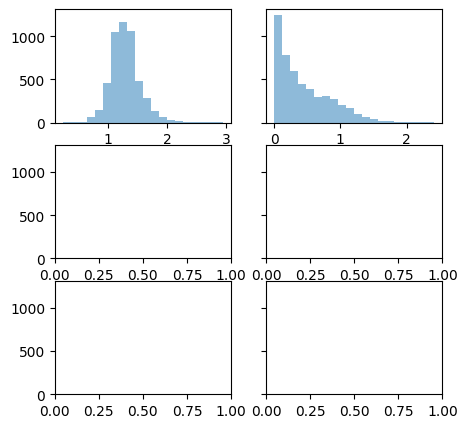

In [57]:
with open("../exp_configs/master_baseline_exp.yaml", "r") as f:
    yaml_config = yaml.safe_load(f)
    
# Parse yaml to namespace and merge (DictConfig)
yaml_dictconfig = OmegaConf.create(yaml_config)

# Create output folder
os.makedirs(yaml_dictconfig.output_folder, exist_ok=True)
# Figure out whether we need to generate the data
use_saved_data = yaml_dictconfig.get('use_saved_data', False)
df_data = {}
if use_saved_data:
    # Use pickle dict to plot with
    for label, pickle_path in yaml_dictconfig.pickle_dict.items():
        df_data[label] = pd.read_pickle(pickle_path)
    labels = yaml_dictconfig.pickle_dict.keys()
else:
    # Use eval folder dict to save as pickles and make new picle dict
    for label, eval_folder_path in yaml_dictconfig.eval_folder_dict.items():
        df_data[label] = process(eval_folder_path, yaml_dictconfig.debug_max)
        safe_label = label.replace(' ', '_')
        safe_label = re.sub(r'[^\w\-_\.]', '', safe_label)
        pickle_path = os.path.join(yaml_dictconfig.output_folder, f'{safe_label}.pkl')
        pd.DataFrame(df_data[label]).to_pickle(pickle_path)
    labels = yaml_dictconfig.eval_folder_dict.keys()
    
# if yaml_dictconfig.get('fingerprint_comparison', False):
#     fingerprint_comparison(df_data, labels, yaml_dictconfig.output_folder, yaml_dictconfig.vlines)

# labels = list(yaml_dictconfig.eval_folder_dict.keys())
print(labels)
labels = list(labels)
if yaml_dictconfig.get('fingerprint_comparison', False):
    fingerprint_comparison(df_data, labels, yaml_dictconfig.output_folder, yaml_dictconfig.vlines)


In [58]:
df_data

{'deCIFer-U':       rwp_dirty  rwp_clean  s12_dirty  s12_clean   hd_clean  ws_clean  \
 0      1.456217   1.456218   0.185897   0.185896  14.225655  0.780973   
 1      1.352324   1.352323   0.164088   0.164088   9.578655  0.208738   
 2      0.845845   0.845846   0.662149   0.662150  10.170687  0.122238   
 3      1.295018   1.295020   0.109542   0.109542  12.653431  0.366334   
 4      1.488770   1.488772   0.188452   0.188452  19.658928  0.444303   
 ...         ...        ...        ...        ...        ...       ...   
 4966   1.245664   1.245664   0.131261   0.131261   7.141001  0.334922   
 4967   1.404942   1.404942   0.061609   0.061609   9.082057  0.442211   
 4968   1.251844   1.251842   0.112541   0.112541  26.469061  0.301495   
 4969   1.241363   1.241363   0.126745   0.126746  12.857435  0.345225   
 4970   1.690357   1.690360   0.113691   0.113691  11.576103  0.417437   
 
       r2_dirty  r2_clean  soap_small_distance  soap_large_distance  ...  \
 0    -1.402401 -1.40

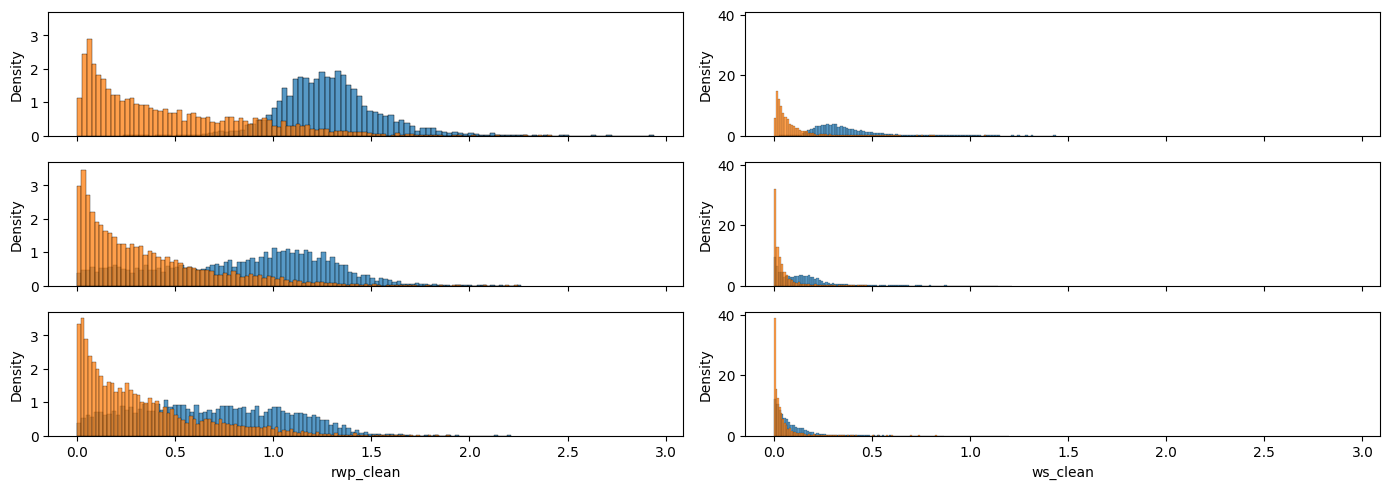

In [88]:
fig, axes = plt.subplots(3, 2, figsize=(14, 5), sharex=True)

n_bins = 100

sns.histplot(df_data['deCIFer-U']['rwp_clean'], bins=n_bins, stat='density', ax=axes[0, 0])
sns.histplot(df_data['deCIFer']['rwp_clean'], bins=n_bins, stat='density', ax=axes[0, 0])

sns.histplot(df_data['deCIFer-U']['ws_clean'], bins=n_bins, stat='density', ax=axes[0, 1])
sns.histplot(df_data['deCIFer']['ws_clean'], bins=n_bins, stat='density', ax=axes[0, 1])

sns.histplot(df_data['deCIFer-U\\n(w/ comp.)']['rwp_clean'], bins=n_bins, stat='density', ax=axes[1, 0])
sns.histplot(df_data['deCIFer\\n(w/ comp.)']['rwp_clean'], bins=n_bins, stat='density', ax=axes[1, 0])

sns.histplot(df_data['deCIFer-U\\n(w/ comp.)']['ws_clean'], bins=n_bins, stat='density', ax=axes[1, 1])
sns.histplot(df_data['deCIFer\\n(w/ comp.)']['ws_clean'], bins=n_bins, stat='density', ax=axes[1, 1])

sns.histplot(df_data['deCIFer-U\\n(w/ comp. & spg.)']['rwp_clean'], bins=n_bins, stat='density', ax=axes[2, 0])
sns.histplot(df_data['deCIFer\\n(w/ comp. & spg.)']['rwp_clean'], bins=n_bins, stat='density', ax=axes[2, 0])

sns.histplot(df_data['deCIFer-U\\n(w/ comp. & spg.)']['ws_clean'], bins=n_bins, stat='density', ax=axes[2, 1])
sns.histplot(df_data['deCIFer\\n(w/ comp. & spg.)']['ws_clean'], bins=n_bins, stat='density', ax=axes[2, 1])

# Get ylim values for left and right columns
left_ylim = max(ax.get_ylim()[1] for ax in [axes[0, 0], axes[1, 0], axes[2, 0]])
right_ylim = max(ax.get_ylim()[1] for ax in [axes[0, 1], axes[1, 1], axes[2, 1]])

# Apply same ylim to all left-side and right-side axes
for ax in [axes[0, 0], axes[1, 0], axes[2, 0]]:
    ax.set_ylim(0, left_ylim)

for ax in [axes[0, 1], axes[1, 1], axes[2, 1]]:
    ax.set_ylim(0, right_ylim)

fig.tight_layout()
plt.show()